## 作成したデータからLasso回帰を実施し、それぞれの特徴量の重要度を可視化する




In [ ]:
!pip install -q shap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy import stats
import shap

In [ ]:
# データの読み込み
df = pd.read_csv("learning_Li_battery_data.csv")

In [ ]:
df.head()

,num_steps,nelements,max_delta_volume,average_voltage,capacity_grav,fracA_discharge,stability_charge,minimum CN_VoronoiNN,maximum CN_VoronoiNN,range CN_VoronoiNN,...,minimum local difference in GSvolume_pa,maximum local difference in GSvolume_pa,mean local difference in GSvolume_pa,minimum local difference in SpaceGroupNumber,maximum local difference in SpaceGroupNumber,avg_dev local difference in SpaceGroupNumber,0-norm,2-norm,frac s valence electrons,frac p valence electrons
0,2,3,0.008674,3.645088,137.171754,0.250000,0.037008,5.999755,10.195544,4.195789,...,1.140000,7.084399,2.644168,113.035858,212.940334,33.974522,4,0.630840,0.292135,0.359551
1,1,3,0.003674,3.555958,69.825436,0.250000,0.089504,5.999351,8.565770,2.566419,...,1.215000,6.936504,3.498748,156.870787,216.998680,22.156506,4,0.607362,0.298851,0.367816
2,1,4,0.078912,3.637514,148.887306,0.142857,0.067563,4.363747,11.904116,7.540370,...,1.966086,22.455000,6.001459,10.000000,213.100189,44.926378,4,0.699702,0.274390,0.481707
3,1,3,0.024693,2.901634,184.256618,0.181818,0.078001,5.979264,9.364866,3.385601,...,1.208721,7.730853,3.161494,77.542331,188.099741,37.717392,4,0.583095,0.350000,0.400000
4,1,5,0.071289,3.757691,113.645161,0.100000,0.045275,4.070083,10.731594,6.661512,...,1.214808,13.465238,4.284699,10.000000,212.979362,48.159064,5,0.695000,0.314159,0.504425


## 学習用データの準備

In [ ]:
# 数値データの抽出
df_num = df.select_dtypes(include=["float64", "int64"])

In [ ]:
# 目的変数の設定
target = "capacity_grav"

In [ ]:
# 入力変数と出力変数の切り分け
y = df_num[target].values
x = df_num.drop(labels=[target], axis=1)

In [ ]:
# データ数確認
type(x), x.shape, type(y), y.shape

(pandas.core.frame.DataFrame, (2391, 72), numpy.ndarray, (2391,))

In [ ]:
# 学習用データとテスト用データに分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Lasso回帰

In [ ]:
# モデルの定義
lasso = Lasso(alpha=1)

In [ ]:
# モデルの学習
lasso.fit(x_train, y_train)

Lasso(alpha=1)

In [ ]:
# モデルの検証
print('train score : ', lasso.score(x_train, y_train))
print('test score : ', lasso.score(x_test, y_test))

train score :  0.7921679440771086
test score :  0.7850823211058876


In [ ]:
# 0 になっている特徴量の数
print('元の特徴量の数 : ', x.shape[1])
print('Lasso の特徴量 : ', np.sum(lasso.coef_ == 0))

元の特徴量の数 :  72
Lasso の特徴量 :  44


In [ ]:
# 推論
y_pred =lasso.predict(x_test)

In [ ]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

35.27237021780077

In [ ]:
# 決定係数
r2_score(y_test, y_pred)

0.7850823211058876

In [ ]:
dict = {"RMSE":np.sqrt(mean_squared_error(y_test, y_pred)), "決定係数":r2_score(y_test, y_pred)}

In [ ]:
pd.DataFrame(dict, index=["Lasso"])

,RMSE,決定係数
Lasso,35.27237,0.785082


## 重要度の評価

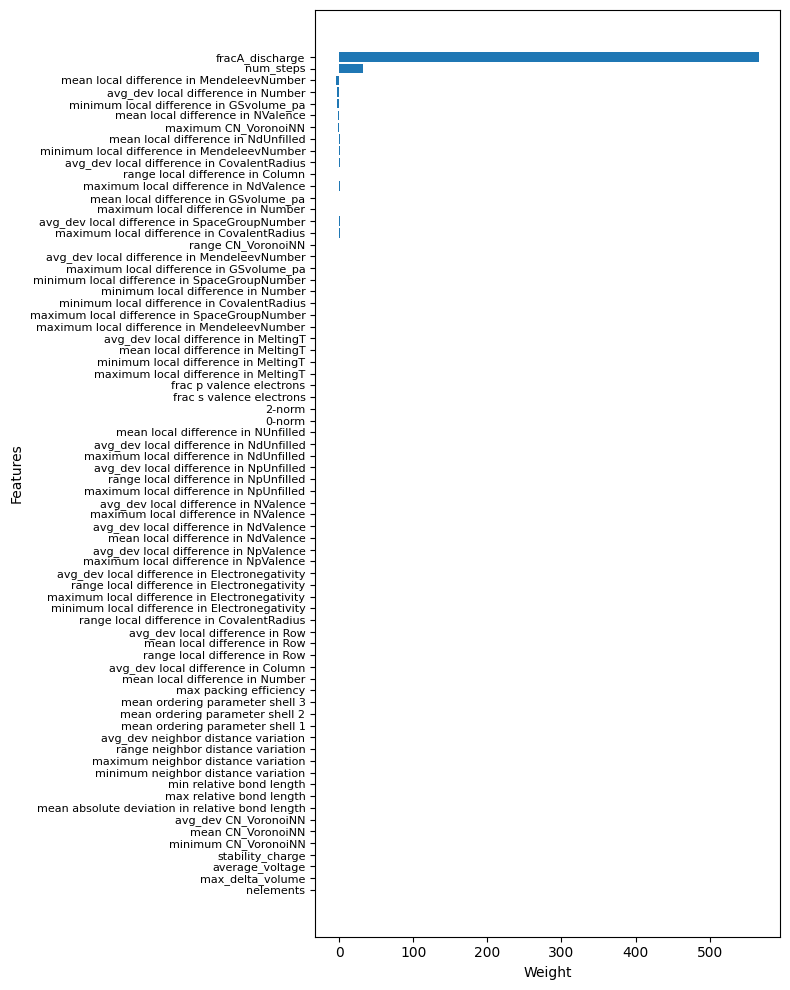

In [ ]:
# 棒グラフによるモデルの重みの可視化

import matplotlib.pyplot as plt

# データフレームの列名と重み係数を取得
columns = df_num.drop(target, axis=1).columns.tolist()
weights = lasso.coef_

# データを重み係数で降順にソート
sorted_data = sorted(zip(columns, weights), key=lambda x: abs(x[1]))
sorted_columns, sorted_weights = zip(*sorted_data)

# プロットを作成
plt.figure(figsize=(8, 10))  # グラフのサイズを調整
plt.barh(y=sorted_columns, width=sorted_weights)

# ラベルの設定
plt.xlabel('Weight')  # x軸ラベル
plt.ylabel('Features')  # y軸ラベル

# 軸の設定
plt.yticks(fontsize=8)  # y軸の文字サイズを調整

plt.tight_layout()
plt.show()

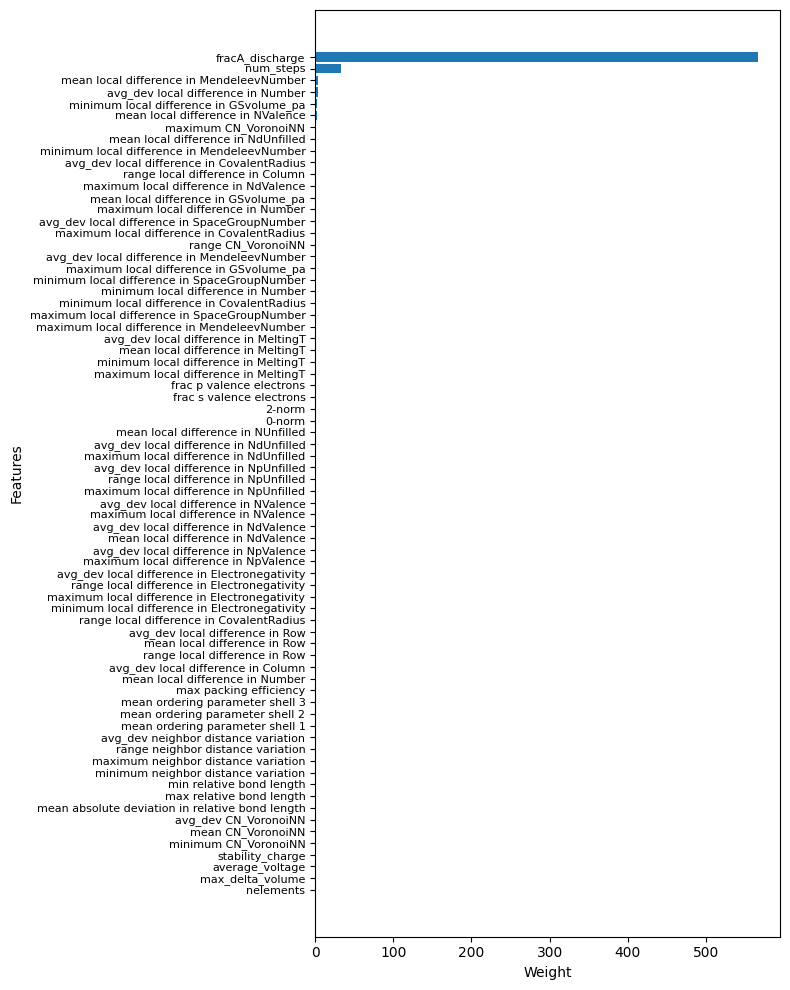

In [ ]:
# 棒グラフによるモデルの重みの絶対値の可視化

# データフレームの列名と重み係数を取得
columns = df_num.drop(target, axis=1).columns.tolist()
weights = abs(lasso.coef_)

# データを重み係数で降順にソート
sorted_data = sorted(zip(columns, weights), key=lambda x: abs(x[1]))
sorted_columns, sorted_weights = zip(*sorted_data)

# プロットを作成
plt.figure(figsize=(8, 10))  # グラフのサイズを調整
plt.barh(y=sorted_columns, width=sorted_weights)

# ラベルの設定
plt.xlabel('Weight')  # x軸ラベル
plt.ylabel('Features')  # y軸ラベル

# 軸の設定
plt.yticks(fontsize=8)  # y軸の文字サイズを調整

plt.tight_layout()
plt.show()

## 重みの大きな変数
- fracA_discharge
- num_steps


In [ ]:
# 電荷量の重量比の散布図と相関係数を算出する関数
def corr_plot(column_name, target):
    r, pvalue = stats.pearsonr(df[column_name], df[target])
    print(f'相関係数：{r}')
    print(f'p値{pvalue:.3f}')

    if pvalue > 0.05:
        print("母相関係数は0であるため、相関があるとは言えない")
    else:
        print("母相関係数は0ではないため、相関がある")

    plt.scatter(x=df[column_name], y=df[target])
    plt.xlabel(column_name)
    plt.ylabel(target)
    plt.title("Scatter Plot of {} vs {}".format(column_name, target))
    plt.show()

相関係数：0.5422359457877547
p値0.000
母相関係数は0ではないため、相関がある


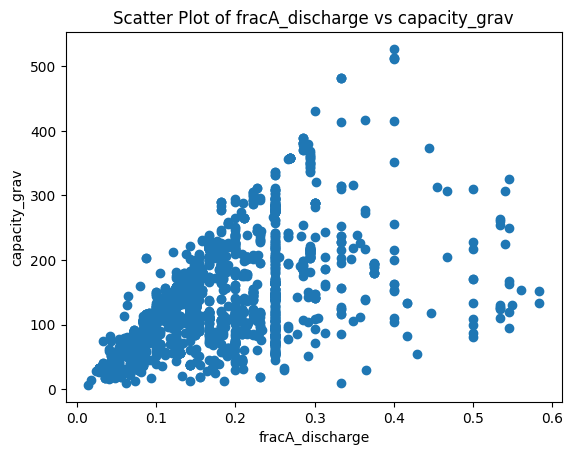

In [ ]:
# 放電時のLiイオンの割合と電荷量の重量比の散布図
corr_plot("fracA_discharge", target)

相関係数：0.5030467482712309
p値0.000
母相関係数は0ではないため、相関がある


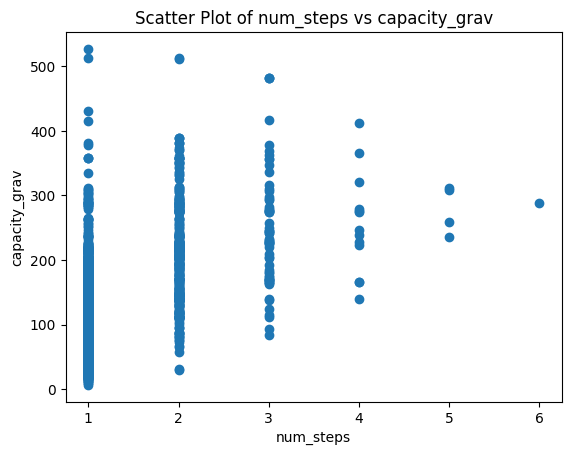

In [ ]:
# ステップ数と電荷量の重量比の散布図
corr_plot("num_steps", target)

上記より下記の要素が電荷量の重量比と相関がある
- 放電時のLiイオンの割合
- ステップ数




In [ ]:
# SHAPによる可視化
explainer = shap.Explainer(lasso.predict, x_train, feature_names=df_num.drop(labels=[target], axis=1).columns.tolist())
shap_values = explainer(x_test)

PermutationExplainer explainer: 480it [00:18, 14.16it/s]                         


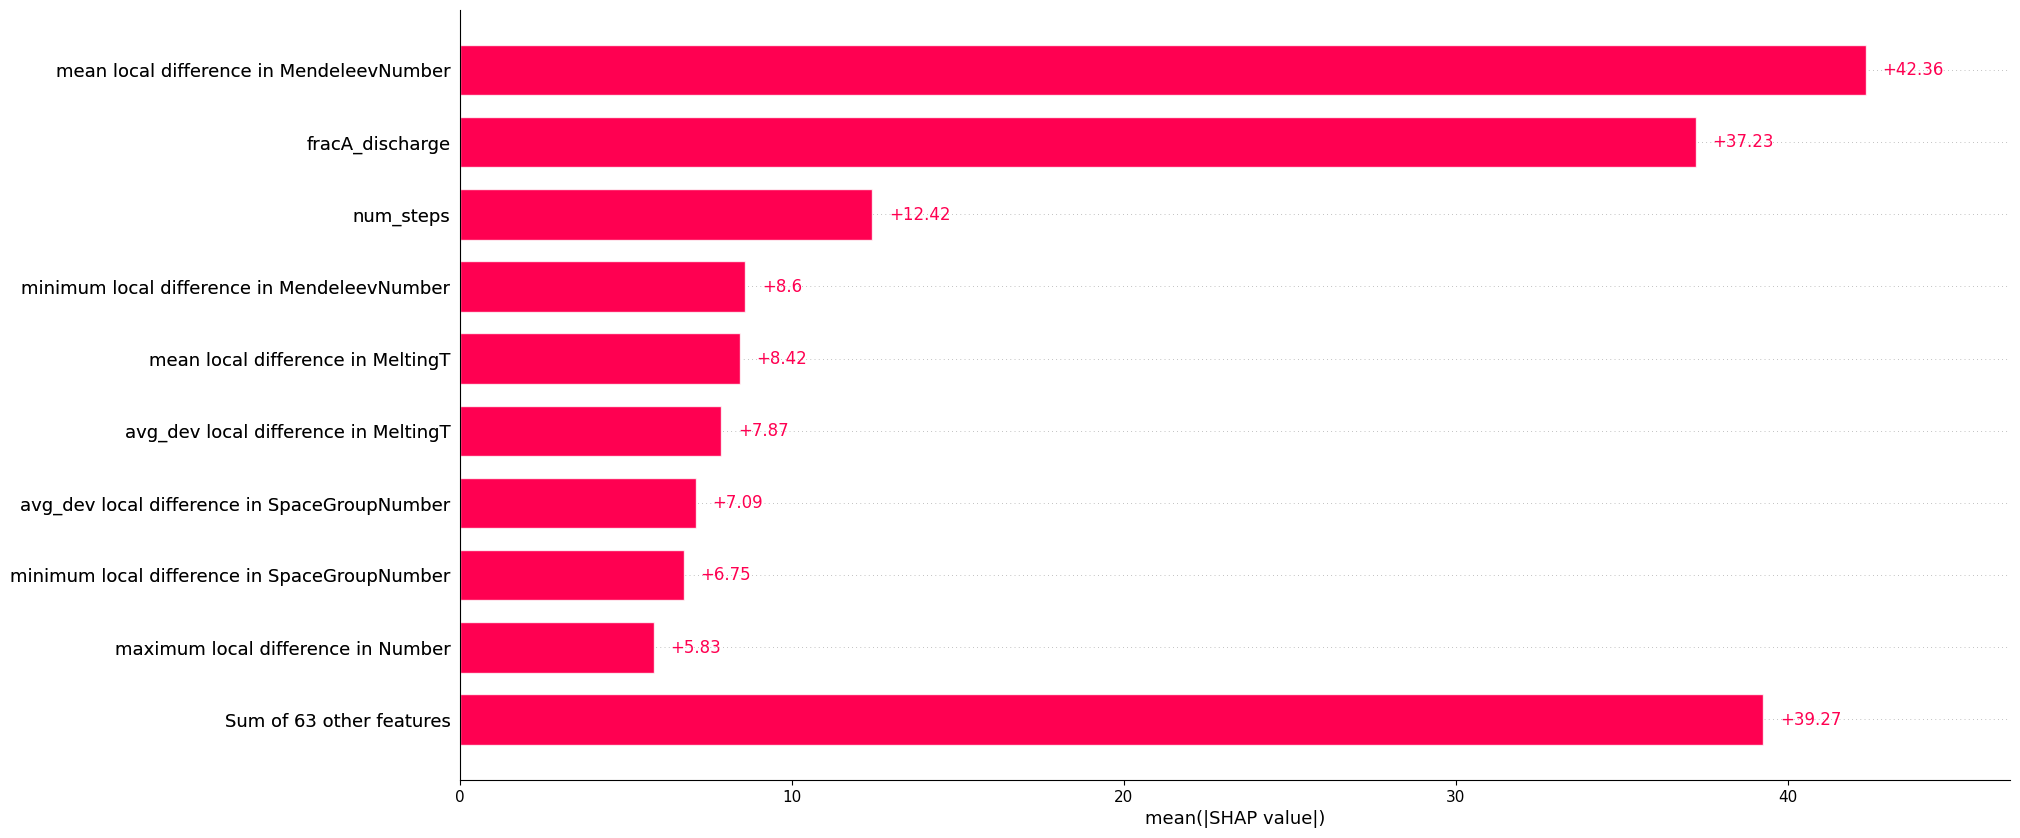

In [ ]:
shap.initjs()

shap.plots.bar(shap_values, show=False)

plt.gcf().set_size_inches(20, 10)

相関係数：-0.07503534495829738
p値0.000
母相関係数は0ではないため、相関がある


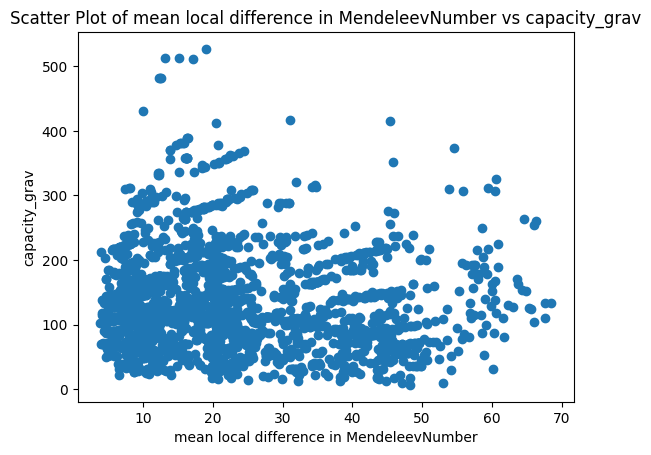

In [ ]:
# 各原子のメンデレーフ数の差の平均値と電荷量の重量比の散布図
corr_plot("mean local difference in MendeleevNumber", target)

相関係数：0.015228074145156704
p値0.457
母相関係数は0であるため、相関があるとは言えない


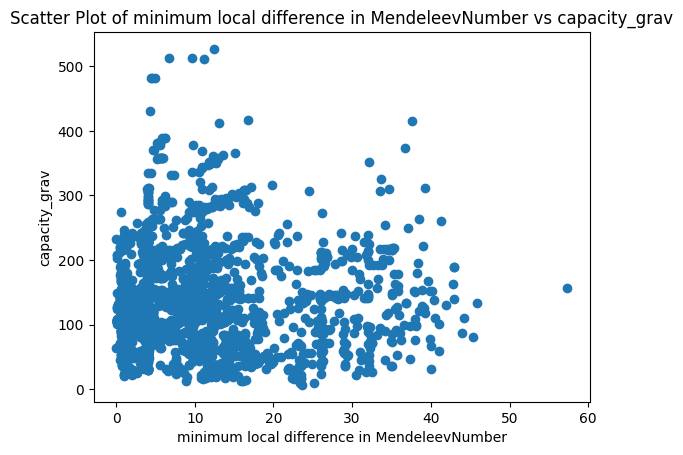

In [ ]:
# 各原子のメンデレーフ数の差の最小値と電荷量の重量比の散布図
corr_plot("minimum local difference in MendeleevNumber", target)

相関係数：-0.03194423002864885
p値0.118
母相関係数は0であるため、相関があるとは言えない


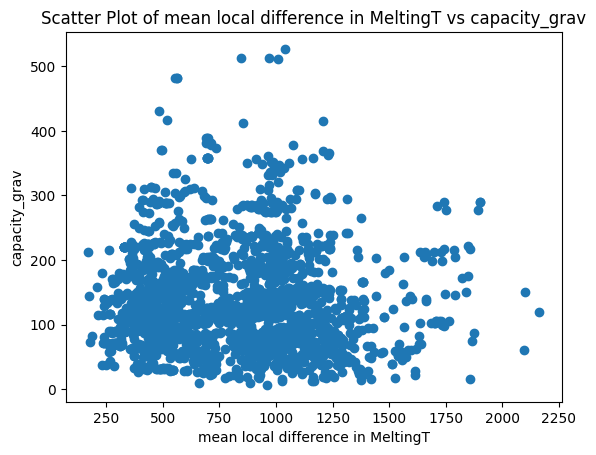

In [ ]:
# 各原子の融解度の平均と電荷量の重量比の散布図
corr_plot("mean local difference in MeltingT", target)

相関係数：0.13618591260351026
p値0.000
母相関係数は0ではないため、相関がある


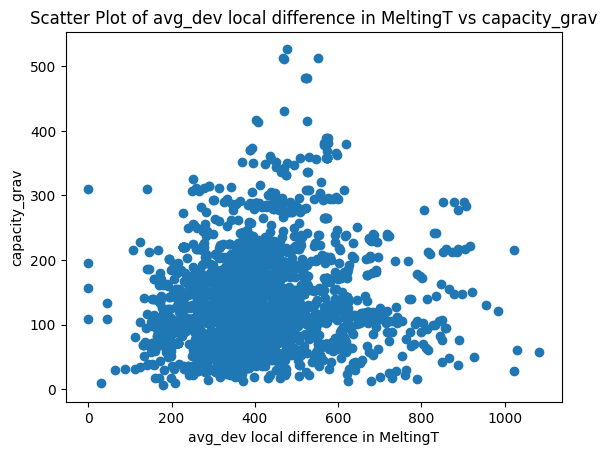

In [ ]:
# 各原子の融解度の平均絶対偏差と電荷量の重量比の散布図
corr_plot("avg_dev local difference in MeltingT", target)

相関係数：-0.0402310316658538
p値0.049
母相関係数は0ではないため、相関がある


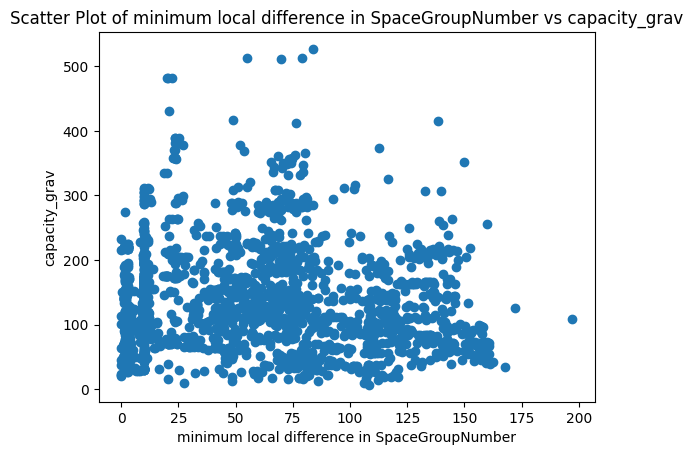

In [ ]:
# 各原子の周期表の位置の最小値と電荷量の重量比の散布図
corr_plot("minimum local difference in SpaceGroupNumber", target)

相関係数：0.2534016305449492
p値0.000
母相関係数は0ではないため、相関がある


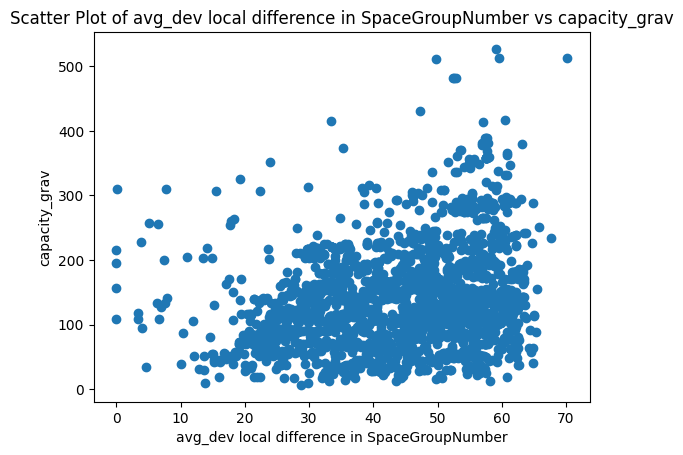

In [ ]:
# 各原子の周期表の位置の平均絶対偏差と電荷量の重量比の散布図
corr_plot("avg_dev local difference in SpaceGroupNumber", target)

相関係数：-0.27260391476829543
p値0.000
母相関係数は0ではないため、相関がある


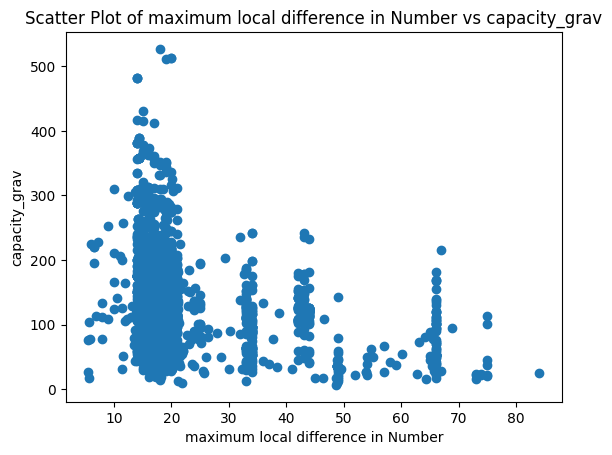

In [ ]:
# 近傍の原子番号の差の最大値と電荷量の重量比の散布図
corr_plot("maximum local difference in Number", target)

## SHAPで新たに重要度が高かった以下の変数は電荷量の重量比と相関がある

- 各原子のメンデレーフ数の差の平均値
- 各原子の融解度の平均絶対偏差
- 各原子の周期表の位置の最小値
- 各原子の周期表の位置の平均絶対偏差
- 近傍の原子番号の差の最大値

###### Lasso回帰においては周期表や原子番号等の重要度が高い結果となった